# AdaDPS

AdaDPS utilizes auxiliary knowledge, such as public datasets, to achieve a better privacy-utility tradeoff.

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00233/CNAE-9.data

--2023-02-06 14:33:24--  https://archive.ics.uci.edu/ml/machine-learning-databases/00233/CNAE-9.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1851120 (1.8M) [application/x-httpd-php]
Saving to: ‘CNAE-9.data.4’

CNAE-9.data.4       100%[===================>]   1.76M  1.64MB/s    in 1.1s    

2023-02-06 14:33:26 (1.64 MB/s) - ‘CNAE-9.data.4’ saved [1851120/1851120]



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
import random
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split

from aijack.defense import GeneralMomentAccountant
from aijack.defense.dp.manager.dp_manager import DPSGDManager, AdaDPSManager

lot_size = 1
batch_size = 1
iterations = 200
sigma = 1.0
l2_norm_clip = 1
delta = 1e-3
lr = 0.01
criterion = nn.CrossEntropyLoss()

torch.manual_seed(42)
random.seed(42)
plt.style.use("ggplot")

In [3]:
df = pd.read_csv("CNAE-9.data", header=None)
X = df[range(1, df.shape[1])].values
y = df[[0]].values.reshape(-1) - 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_pub, y_train, y_pub = train_test_split(
    X_train, y_train, test_size=0.4, random_state=42
)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
X_pub = torch.Tensor(X_pub)
y_train = torch.Tensor(y_train).to(torch.long)
y_test = torch.Tensor(y_test).to(torch.long)
y_pub = torch.Tensor(y_pub).to(torch.long)

trainset = TensorDataset(X_train, y_train)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(df.shape[1] - 1, 9)

    def forward(self, x):
        out = self.fc1(x)
        return out

In [5]:
def evaluate_dpoptimizer(accountant, privacy_manager):
    accountant.reset_step_info()
    accountant.add_step_info(
        {"sigma": sigma},
        lot_size / len(trainset),
        iterations * (len(trainset) / lot_size),
    )
    estimated_epsilon = accountant.get_epsilon(delta=delta)
    print(f"estimated epsilon is {estimated_epsilon}")

    accountant.reset_step_info()
    dpoptimizer_cls, lot_loader, batch_loader = privacy_manager.privatize(
        noise_multiplier=sigma
    )

    net = Net()
    optimizer = dpoptimizer_cls(net.parameters(), lr=lr)

    res = []
    for epoch in tqdm(range(iterations)):  # loop over the dataset multiple times
        for X_lot, y_lot in lot_loader(optimizer):
            for X_batch, y_batch in batch_loader(TensorDataset(X_lot, y_lot)):
                optimizer.zero_grad()
                loss = criterion(net(X_batch), y_batch)
                loss.backward()
                optimizer.step()
        res.append(criterion(net(X_test), y_test).item())

    return res


def evaluate_adadps(accountant, privacy_manager):
    accountant.reset_step_info()
    accountant.add_step_info(
        {"sigma": sigma},
        lot_size / len(trainset),
        iterations * (len(trainset) / lot_size),
    )
    estimated_epsilon = accountant.get_epsilon(delta=delta)
    print(f"estimated epsilon is {estimated_epsilon}")

    accountant.reset_step_info()
    dpoptimizer_cls, lot_loader, batch_loader = privacy_manager.privatize(
        noise_multiplier=sigma
    )

    net = Net()
    optimizer = dpoptimizer_cls(net.parameters(), lr=lr)

    res = []
    for epoch in tqdm(range(iterations)):  # loop over the dataset multiple times
        for X_lot, y_lot in lot_loader(optimizer):
            for X_batch, y_batch in batch_loader(TensorDataset(X_lot, y_lot)):
                optimizer.zero_grad()
                pub_idx = random.sample(list(range(X_pub.shape[0])), X_batch.shape[0])
                loss = criterion(net(X_pub[pub_idx]), y_pub[pub_idx])
                loss.backward()
                optimizer.step_public()

                optimizer.zero_grad()
                loss = criterion(net(X_batch), y_batch)
                loss.backward()
                optimizer.step()
        res.append(criterion(net(X_test), y_test).item())

    return res

In [6]:
accountant = GeneralMomentAccountant(
    noise_type="Gaussian",
    backend="cpp",
)

privacy_manager = DPSGDManager(
    accountant,
    optim.SGD,
    l2_norm_clip=l2_norm_clip,
    dataset=trainset,
    lot_size=lot_size,
    batch_size=batch_size,
    iterations=iterations,
)

res1 = evaluate_dpoptimizer(accountant, privacy_manager)

estimated epsilon is 2.7860065342521563


100%|██████████| 200/200 [00:50<00:00,  3.99it/s]


In [7]:
accountant = GeneralMomentAccountant(
    noise_type="Gaussian",
    backend="cpp",
)

privacy_manager = AdaDPSManager(
    accountant,
    optim.SGD,
    l2_norm_clip=l2_norm_clip,
    dataset=trainset,
    lot_size=batch_size,
    batch_size=batch_size,
    iterations=iterations,
)

res2 = evaluate_adadps(accountant, privacy_manager)

estimated epsilon is 2.7860065342521563


100%|██████████| 200/200 [01:00<00:00,  3.30it/s]


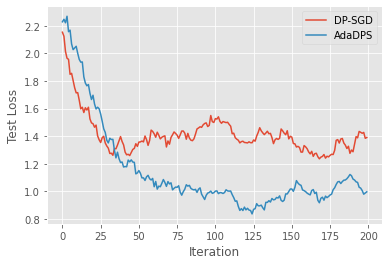

In [8]:
plt.plot(res1, label="DP-SGD")
plt.plot(res2, label="AdaDPS")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Test Loss")
plt.show()